# Data Mining Workflow

## Dataset

(This is a Kaggle dataset)

The probelem concerns a company that wants to learn and why are their best and most experienced employees are leaving early. They want to predict which employees will leave next.

Fields in the dataset include:

Last evaluation <br>
Number of projects <br>
Average monthly hours <br>
Time spent at the company <br>
Whether they have had a work accident <br>
Whether they have had a promotion in the last 5 years <br>
Department <br>
Salary <br>
Whether the employee has left <br>


## Using the SAS Python  API

Note: This API converts python syntax language into CAS Language, which is sent to the SAS server for execution (the execution is not done locally). The results are then brought back into Python

This example illustrates fitting and comparing several Machine Learning algorithms for classifying the binary label 'left' in the Human Resource data set.

The steps include:                              
                                                                      
1. PREPARE AND EXPLORE  
  a) Data is loaded into CAS <br>
  b) Explore data, distributions, correlations, and visualizations 
<br>                                                                      
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model using Logistic Regression <br>
  b) Fit a model using Gradient Boosting  <br>
  c) Hands-on Problem - Fit a model using Random Forest
  <br>                                                                      
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts <br>
  d) Hands-on Problem - Score, Assess, ROC charts for Random Forest model and Compare with Logistic and Gradient Boosting 

## Import packages and modules, Start CAS Session & Load HR dataset

In [16]:
import swat
import numpy as np
import pandas as pd
from swat.render import render_html
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sea
sea.set(style="whitegrid", color_codes=True)
from pprint import pprint
from IPython.core.display import display, HTML


# Define directory and data file name
hrdata_dir = '<Path_to_data>'
indataset     = 'hr_data'

## Server, port, username, password
cashost='localhost'
casport=5570

# Start a CAS session
sess = swat.CAS(cashost, casport, 'userid', 'password')

# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['simple','cardinality', 'sampling', 'fedSQL','regression', 'decisionTree', 'neuralNet', 'astore','autotune']
[sess.builtins.loadactionset(i) for i in actionsets]

# Create a CAS library called datalib pointing to the defined directory
datalib = sess.addCaslib('datalib', datasource = 'path', path = hrdata_dir)

# Push the relevant table In-Memory
## Note, this is a server side data load, not being loaded from the client
inMem = sess.loadTable('HR_comma_sep.csv',caslib='datalib', casOut = dict(name='hr_data', caslib='datalib'))

NOTE: Added action set 'simple'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.
NOTE: 'datalib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'datalib'.
NOTE: Cloud Analytic Services made the file HR_comma_sep.csv available as table HR_DATA in caslib datalib.


## Data Exploration and Preparation

## Investigate the data

In [17]:
# Store the inMem data object as hr
hr=inMem.casTable

# Print out the first 10 rows of the dataset
hr.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,1.0,0.0,sales,low
1,0.80,0.86,5.0,262.0,6.0,0.0,1.0,0.0,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,1.0,0.0,sales,medium
3,0.72,0.87,5.0,223.0,5.0,0.0,1.0,0.0,sales,low
4,0.37,0.52,2.0,159.0,3.0,0.0,1.0,0.0,sales,low
5,0.41,0.50,2.0,153.0,3.0,0.0,1.0,0.0,sales,low
6,0.10,0.77,6.0,247.0,4.0,0.0,1.0,0.0,sales,low
7,0.92,0.85,5.0,259.0,5.0,0.0,1.0,0.0,sales,low
8,0.89,1.00,5.0,224.0,5.0,0.0,1.0,0.0,sales,low
9,0.42,0.53,2.0,142.0,3.0,0.0,1.0,0.0,sales,low


In [18]:
varlist = ['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years','left']
categoricals=['sales', 'salary']

In [19]:
hr.summary()

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT
0,satisfaction_level,0.09,1.0,14999.0,0.0,0.612834,9191.89,0.248631,0.002030,0.061817,6.560233e+03,9.271344e+02,40.570668,301.869335,0.000000e+00
1,last_evaluation,0.36,1.0,14999.0,0.0,0.716102,10740.81,0.171169,0.001398,0.029299,8.130937e+03,4.394244e+02,23.902904,512.366218,0.000000e+00
2,number_project,2.00,7.0,14999.0,0.0,3.803054,57042.00,1.232592,0.010064,1.519284,2.397200e+05,2.278622e+04,32.410597,377.871486,0.000000e+00
3,average_montly_hours,96.00,310.0,14999.0,0.0,201.050337,3015554.00,49.943099,0.407797,2494.313175,6.436879e+08,3.740971e+07,24.841092,493.015379,0.000000e+00
4,time_spend_company,2.00,10.0,14999.0,0.0,3.498233,52470.00,1.460136,0.011922,2.131998,2.155280e+05,3.197570e+04,41.739248,293.417853,0.000000e+00
5,Work_accident,0.00,1.0,14999.0,0.0,0.144610,2169.00,0.351719,0.002872,0.123706,2.169000e+03,1.855342e+03,243.219298,50.353901,0.000000e+00
6,left,0.00,1.0,14999.0,0.0,0.238083,3571.00,0.425924,0.003478,0.181411,3.571000e+03,2.720807e+03,178.897664,68.458359,0.000000e+00
7,promotion_last_5years,0.00,1.0,14999.0,0.0,0.021268,319.00,0.144281,0.001178,0.020817,3.190000e+02,3.122155e+02,678.394259,18.052984,4.327074e-72


## Plot Numeric Variable Distribution - CAS/Python

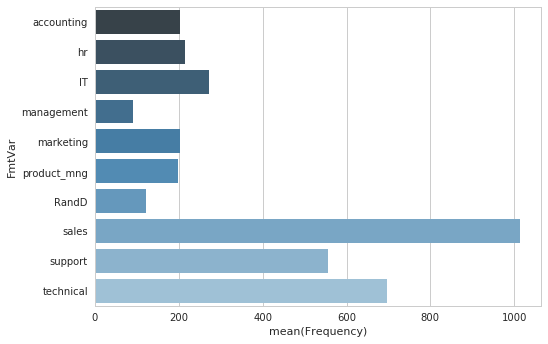

In [20]:
#Which department has most individuals leaving?

hr_left=hr[(hr.left == 1)] # data selection with a CAS object
df_department=hr_left[['sales']].freq()
sea.barplot(x='Frequency', y= 'FmtVar',data=df_department['Frequency'], palette="Blues_d");

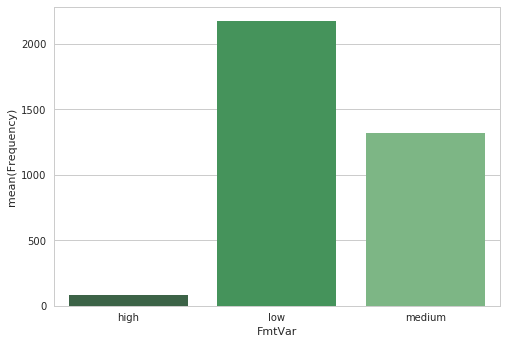

In [21]:
df_salary=hr_left[['salary']].freq()
sea.barplot(x= 'FmtVar', y= 'Frequency', data=df_salary['Frequency'], palette="Greens_d");

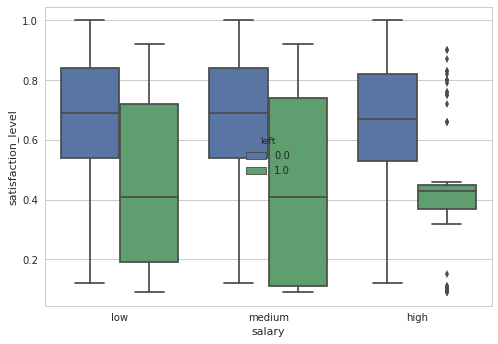

In [22]:
#Distribution of Salary level for satisfaction level

df_all=hr.to_frame()
sea.boxplot(x=df_all['salary'], y=df_all['satisfaction_level'], hue=df_all['left'])

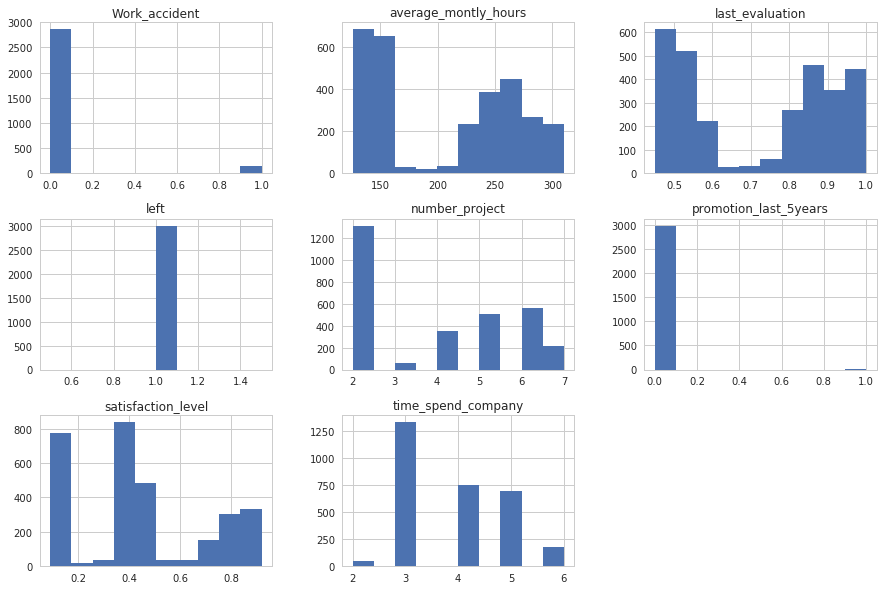

In [23]:
# Use the built in hist() method to plot the distribution of every variable
hr_left.hist(figsize = (15, 10));

In [28]:
#Get index number for the casTable using the get_loc extension
hr.columns.get_loc('time_spend_company')

4

In [29]:
hr.columns.get_loc('satisfaction_level')

0

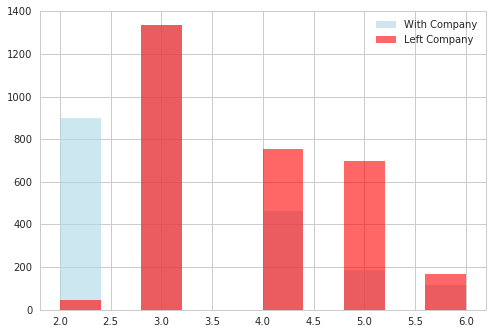

In [24]:
#Experienced employees - whether they decided to leave or stayed with the company
x=hr[(hr.left == 0)].ix[:,4].values
y=hr[(hr.left == 1)].ix[:,4].values

plt.figure()
plt.hist(x, bins=10, alpha=0.6, color='lightblue', label='With Company')
plt.hist(y, bins=10, alpha=0.6, color ='red', label='Left Company')
plt.legend()
plt.show()

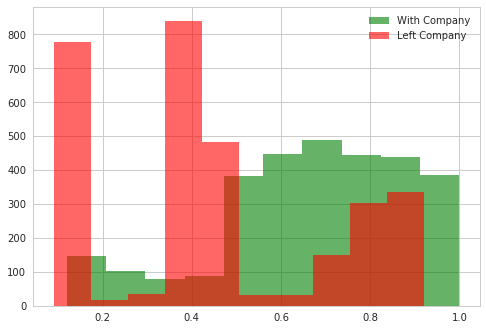

In [25]:
#Satisfaction level of employees whether they decided to leave or stayed with the company
x=hr[(hr.left == 0)].ix[:,0].values
y=hr[(hr.left == 1)].ix[:,0].values

plt.figure()
plt.hist(x, bins=10, alpha=0.6, color='green', label='With Company')
plt.hist(y, bins=10, alpha=0.6, color ='red', label='Left Company')
plt.legend()
plt.show()

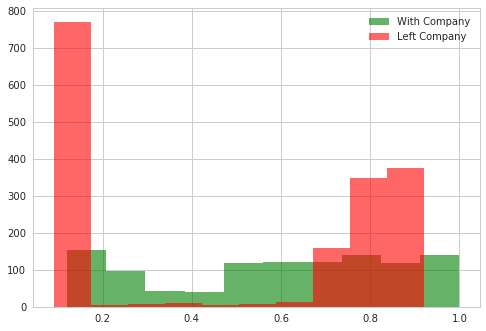

In [38]:
#Are there employees with more years of experience with higher performance evaluation and satisfied that are leaving? 
#Hint: Change the code below to incorporate time_spend_company and last_evaluation...

x=hr[((hr.time_spend_company > 3) & (hr.time_spend_company < 8)) & (hr.last_evaluation >= 0.8) & (hr.left == 0)].ix[:,0].values
y=hr[((hr.time_spend_company > 3) & (hr.time_spend_company < 8)) & (hr.last_evaluation >= 0.8) & (hr.left == 1)].ix[:,0].values

plt.figure()
plt.hist(x, bins=10, alpha=0.6, color='green', label='With Company')
plt.hist(y, bins=10, alpha=0.6, color ='red', label='Left Company')
plt.legend()
plt.show()

#Employees with time spend with company between 4 & 7 that left the company had a high satisfaction score 0.7 to 0.9
#...what other insights can we get?

### Correlation Analysis

Are there any relationships between these variables? 

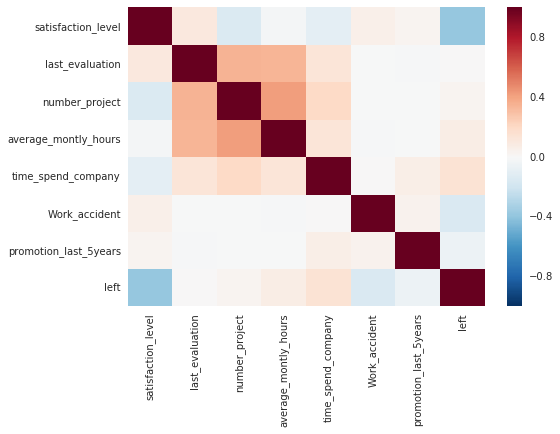

In [35]:
corr=hr.correlation(inputs=varlist)
corr_tbl=corr['Correlation']
indexed_df = corr_tbl.set_index(['Variable'])
del indexed_df.index.name
sea.heatmap(indexed_df, xticklabels=indexed_df.columns.values,yticklabels=indexed_df.columns.values)

### Based on the histogram analysis - create a high risk employee profile and re-run correlations?

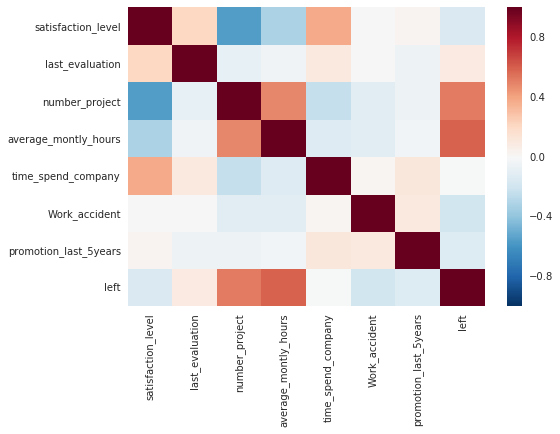

In [46]:
#We will use the insights from the histogram analysis to see if there are other variables that have stronger correlations
#with the label "left" 

corr=hr[((hr.time_spend_company > 3) & (hr.time_spend_company < 8)) & (hr.last_evaluation >= 0.8)].correlation(inputs=varlist) # Change data selection for hr...
corr_tbl=corr['Correlation']
indexed_df = corr_tbl.set_index(['Variable'])
del indexed_df.index.name
sea.heatmap(indexed_df, xticklabels=indexed_df.columns.values,yticklabels=indexed_df.columns.values)

## Partition Data into Training and Validation Sets 

In [47]:
target="left"
interval_inputs = ['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'promotion_last_5years']
class_inputs=['sales', 'salary']
class_vars= [target] + class_inputs
all_inputs=interval_inputs + class_inputs

In [48]:
sess.sampling.stratified(
  table={"name":"hr_data", "groupBy":target},
  output={"casOut":{"name":"hr_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)


NOTE: Using SEED=395905395 for sampling.


[outputSize]

 {'outputNObs': 14999.0, 'outputNVars': 11}

[STRAFreq]

 Frequencies
 
    ByGrpID          left   NObs  NSamp
 0        0             0  11428   8000
 1        1             1   3571   2500

[OutputCasTables]

     casLib     Name Label   Rows  Columns  \
 0  datalib  hr_part        14999       11   
 
                                 casTable  
 0  CASTable('hr_part', caslib='datalib')  

+ Elapsed: 0.139s, user: 0.024s, sys: 0.011s, mem: 18.6mb

## Build Classifiers 

### Logistic Regression

In [49]:
lr = sess.regression.logistic(
  table={"name":"hr_part"},
  classVars=class_vars,
  model={
    "depVars":[{"name":'left', "options":{"event":"1"}}],
    "effects":all_inputs
  },
  partByVar={"name": "_partind_", "train": "1", "valid": "0"},
  selection={"method":"BACKWARD"},
  output={"casOut":{"name":"_scored_logistic", "replace":True}, "copyVars":"ALL"}
)

# Output model statistics
render_html(lr)

# Compute _pred0_ variable (1-_pred_)
sess.dataStep.runCode(
  code="data _scored_logistic; set _scored_logistic; _pred0_=1-_pred_; run;"
)

NOTE: Convergence criterion (GCONV=1E-8) satisfied.


Model Information 
 RowId 
 Description 
 Value 
 
 
 DATA Data Source HR_PART 
 RESPONSEVAR Response Variable left 
 DIST Distribution Binary 
 LINK Link Function Logit 
 TECH Optimization Technique Newton-Raphson with Ridging 
 
 
 
 
 Number of Observations 
 RowId 
 Description 
 Total 
 Training 
 Validation 
 
 
 NREAD Number of Observations Read 14999 10500 4499 
 NUSED Number of Observations Used 14999 10500 4499 
 
 
 
 
 Response Profile 
 Ordered Value 
 left 
 left 
 Total Frequency 
 Training 
 Validation 
 Probability Modeled 
 
 
 1 0 0 11428 8000 3428 
 2 1 1 3571 2500 1071 * 
 
 
 
 
 Class Level Information 
 Class 
 Levels 
 Values 
 
 
 sales 10 IT RandD accounting hr management marketing product_mng sales support technical 
 salary 3 high low medium 
 
 
 
 
 Selection Information 
 Description 
 Value 
 Numeric Value 
 
 
 Selection Method Backward nan 
 Select Criterion SBC nan 
 Stop Criterion SBC nan 
 Effect Hierarchy Enforced Single nan 
 Stop Horizon 3 3 
 
 
 
 
 Convergence Status 
 Reason 
 Status 
 Max Gradient 
 
 
 Convergence criterion (GCONV=1E-8) satisfied. 0 1.4679508E-9 
 
 
 
 
 Selection Summary 
 Control 
 Step 
 Effect Removed 
 Number Of Effects 
 SBC 
 Optimal SBC 
 
 
 0 10 9179.2564979 0 
 - 1 sales 9 9133.5197095 1 
 2 last_evaluation 8 9143.8630141 0 
 3 promotion_last_5years 7 9158.1405807 0 
 4 average_montly_hours 6 9217.4520022 0 
 
 
 
 
 Stop Reason 
 Reason 
 Code 
 
 
 Selection stopped at a local minimum of the STOP criterion. 6 
 
 
 
 
 Selection Reason 
 Reason 
 
 
 The model at step 1 is selected. 
 
 
 
 
 Selected Effects 
 Label 
 Effects 
 
 
 Selected Effects: Intercept satisfaction_level last_evaluation number_project average_montly_hours time_spend_company Work_accident promotion_last_5years salary 
 
 
 
 
 Dimensions 
 RowId 
 Description 
 Value 
 
 
 NDESIGNCOLS Columns in Design 11 
 NEFFECTS Number of Effects 9 
 MAXEFCOLS Max Effect Columns 3 
 DESIGNRANK Rank of Design 10 
 OPTPARM Parameters in Optimization 10 
 
 
 
 
 Likelihood Ratio Test 
 Test 
 DF 
 Chi-Square 
 Pr > ChiSq 
 
 
 Likelihood Ratio 9 2483.9132782 0 
 
 
 
 
 Fit Statistics 
 RowId 
 Description 
 Training 
 Validation 
 
 
 M2LL -2 Log Likelihood 9042.4487959 3868.151272 
 AIC AIC (smaller is better) 9062.4487959 3888.151272 
 AICC AICC (smaller is better) 9062.4697703 3888.2002916 
 SBC SBC (smaller is better) 9135.0401013 3952.2673763 
 ASE Average Square Error 0.1398595918 0.1408758981 
 M2LLNULL -2 Log L (Intercept-only) 11526.362074 4938.3285621 
 RSQUARE R-Square 0.2106639811 0.2116948639 
 ADJRSQ Max-rescaled R-Square 0.316132524 0.3176951839 
 MCFADDEN McFadden's R-Square 0.2154984602 0.2167084018 
 MISCLASS Misclassification Rate 0.2042857143 0.2096021338 
 DIFFMEAN Difference of Means 0.2322789251 0.2348192605 
 
 
 
 
 Parameter Estimates 
 Effect 
 salary 
 Parameter 
 Parameter 
 DF 
 Estimate 
 Standard Error 
 Chi-Square 
 Pr > ChiSq 
 
 
 Intercept Intercept Intercept 1 0.0038966573 0.1444735604 0.0007274576 0.9784825278 
 satisfaction_level satisfaction_level satisfaction_level 1 -4.124406336 0.1167258347 1248.5010569 1.75727E-273 
 last_evaluation last_evaluation last_evaluation 1 0.7544528261 0.1774223539 18.082043334 0.0000211587 
 number_project number_project number_project 1 -0.327195835 0.0254468589 165.32828869 7.755262E-38 
 average_montly_hours average_montly_hours average_montly_hours 1 0.0040190388 0.0006208254 41.908821335 9.563024E-11 
 time_spend_company time_spend_company time_spend_company 1 0.2708952065 0.018486395 214.73270028 1.274612E-48 
 Work_accident Work_accident Work_accident 1 -1.53475281 0.1074789091 203.90617365 2.933982E-46 
 promotion_last_5years promotion_last_5years promotion_last_5years 1 -1.37624205 0.2906154084 22.426028649 2.1839419E-6 
 salary high salary high salary_high 1 -1.545343752 0.1550071394 99.3909399 2.072686E-23 
 salary low salary low salary_low 1 0.5465228495 0.0542608151 101.44812428 7.335969E-24 
 salary medium

,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_logistic,14999,12,"CASTable('_scored_logistic', caslib='datalib')"
,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_logistic,14999,13,"CASTable('_scored_logistic', caslib='datalib')"


### Gradient Boosting

In [50]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"hr_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="left",
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"hr_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"left", "_partind_"}
)

# Create p_left0 and p_left1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_left1=_gbt_predp_; 
    p_left0=1-p_left1; end; if _gbt_predname_=0 then do; p_left0=_gbt_predp_; p_left1=1-p_left0; end; run;"""
)

Gradient Boosting Tree for HR_PART 
 Descr 
 Value 
 
 
 Number of Trees 10 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 9 
 Number of Bins 20 
 Number of Variables 9 
 Max Number of Tree Nodes 63 
 Min Number of Tree Nodes 55 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 32 
 Min Number of Leaves 28 
 Maximum Size of Leaves 2931 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for HR_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 satisfaction_level 477.0191263 159.46300448 
 time_spend_company 219.61178696 72.285143689 
 last_evaluation 103.31085211 40.910684355 
 number_project 97.37314011 37.5102576 
 average_montly_hours 59.700110088 19.046412581 
 sales 8.6224119162 1.621486958 
 salary 1.3381620227 1.4530221213 
 Work_accident 0.5306958135 1.5161024463 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 datalib gb_model 604 36 CASTable('gb_model', caslib='datalib')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:114
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:114  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_gb,14999,6,"CASTable('_scored_gb', caslib='datalib')"
,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_gb,14999,8,"CASTable('_scored_gb', caslib='datalib')"


### Random Forest

In [51]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"hr_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="left",
  nTree=20,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAIN",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  OOB=True,
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hr_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"left", "_partind_"},
  vote="PROB"
)

# Create p_b_tgt0 and p_b_tgt1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_left1=_rf_predp_; 
    p_left0=1-p_left1; end; if _rf_predname_=0 then do; p_left0=_rf_predp_; p_left1=1-p_left0; end; run;"""
)

Forest for HR_PART 
 Descr 
 Value 
 
 
 Number of Trees 20 
 Number of Selected Variables (M) 3 
 Random Number Seed 0 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 9 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 465 
 Min Number of Tree Nodes 343 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 19 
 Min Number of Levels 16 
 Max Number of Leaves 233 
 Min Number of Leaves 172 
 Maximum Size of Leaves 1327 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 2.6857142857 
 
 
 
 
 OOB Error With Forest Analytics for HR_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 203 0.0420694594 0.4380013422 0.0346812203 0.1862289459 1 
 1 2 422 0.0390500673 0.4002314133 0.0326112452 0.1805858388 1 
 2 3 599 0.0368800339 0.3171537456 0.0296054024 0.172062205 1 
 3 4 795 0.0336596085 0.2578634868 0.027265868 0.1651237961 1 
 4 5 1028 0.0322172474 0.2285647035 0.0265685735 0.1629986917 1 
 5 6 1239 0.0308077404 0.2069780616 0.0263398737 0.1622956367 1 
 6 7 1416 0.0284128958 0.1820825916 0.024888167 0.1577598395 1 
 7 8 1606 0.0280534351 0.1633814186 0.0239901495 0.1548875382 1 
 8 9 1791 0.0280213496 0.1563014701 0.0234203484 0.1530370817 1 
 9 10 1969 0.0272484756 0.1435421389 0.0229558132 0.1515117593 1 
 10 11 2190 0.0270501953 0.1415149798 0.022854199 0.1511760531 1 
 11 12 2411 0.0271454424 0.1397941394 0.0227279254 0.1507578369 1 
 12 13 2618 0.0274311839 0.1399898008 0.02270253 0.1506735877 1 
 13 14 2798 0.0275238095 0.1362594681 0.0226049399 0.1503493927 1 
 14 15 2970 0.0275238095 0.1340496516 0.0224048643 0.1496825452 1 
 15 16 3155 0.0275238095 0.1319043876 0.0222322355 0.1491047804 1 
 16 17 3349 0.0274285714 0.1313546677 0.0220086029 0.1483529672 1 
 17 18 3575 0.0267619048 0.1284483194 0.0220420536 0.1484656647 1 
 18 19 3759 0.0267619048 0.1278577229 0.0218697985 0.1478844094 1 
 19 20 3944 0.0268571429 0.1242585862 0.0218218584 0.1477222338 1 
 
 
 
 
 Forest for HR_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 satisfaction_level 650.57951067 92.972090885 
 time_spend_company 502.58777127 65.705236602 
 number_project 405.06619166 75.61738136 
 average_montly_hours 351.31958557 34.945440286 
 last_evaluation 188.45323427 24.345922805 
 sales 40.735173201 1.6328804848 
 salary 19.473799635 3.4830435531 
 Work_accident 19.147053149 13.26268857 
 promotion_last_5years 1.1325444539 2.3309553661 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 datalib forest_model 7868 48 CASTable('forest_model', caslib='datalib')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:112
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 8 times)
      0:35    0:112  (occurred 8 times)


,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_rf,14999,7,"CASTable('_scored_rf', caslib='datalib')"
,casLib,Name,Rows,Columns,casTable
0,datalib,_scored_rf,14999,9,"CASTable('_scored_rf', caslib='datalib')"


## Model Comparison

## Score the Models on Validation Data - CAS/Python

In [52]:
# Model assessment function
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_left1"}],      
      response="left",
      event="1",
      pVar={"p_left0"},
      pEvent={"0"}      
    )

def assess_logistic_model(prefix):
    return sess.percentile.assess(
        table={"name":"_scored_" + prefix, "where": "strip(put(_partind_, best.))='0'"},
        inputs=[{"name":"_pred_"}],
        response="left",
        event="1",
        pVar={"_pred0_"},
        pEvent={"0"}
    )


#Logistic Regression Assess data sets
logisticAssess=assess_logistic_model(prefix="logistic") 
logistic_fitstat =logisticAssess.FitStat
logistic_rocinfo =logisticAssess.ROCInfo
logistic_liftinfo=logisticAssess.LIFTInfo

#Gradient Boosting Assess data sets
gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

#Random Forest Assess data sets
rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

In [53]:
# Add new variable to indicate type of model
logistic_liftinfo["Model"]="Logistic Regression"
logistic_rocinfo["Model"]="Logistic Regression"
gb_liftinfo["Model"]="Gradient Boosting"
gb_rocinfo["Model"]="Gradient Boosting"
rf_liftinfo["Model"]="Random Forest"
rf_rocinfo["Model"]="Random Forest"

# Append data
all_liftinfo=logistic_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(rf_liftinfo, ignore_index=True)
all_rocinfo=logistic_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(rf_rocinfo, ignore_index=True)

## Combined Confusion Matrix

In [54]:
# Display stacked confusion matrix using Python with a cut-off of 0.5
print('\n', 'Confusion Matrix Information'.center(42, ' '))
all_rocinfo[round(all_rocinfo['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)


        Confusion Matrix Information       


,Model,TP,FP,FN,TN
0,Logistic Regression,399.0,271.0,672.0,3157.0
1,Gradient Boosting,975.0,23.0,96.0,3405.0
2,Random Forest,983.0,17.0,88.0,3411.0


## Compare Misclassification Rates - Python

In [55]:
# Add misclassification rate calculation
all_rocinfo['Misclassification'] = 1 - all_rocinfo['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = all_rocinfo[round(all_rocinfo['CutOff'], 2)==0.5][['Model', 'Misclassification']].reset_index(drop = True)
miss.sort_values('Misclassification')


   Misclassification Rate Comparison  


,Model,Misclassification
2,Random Forest,0.023339
1,Gradient Boosting,0.026450
0,Logistic Regression,0.209602


## Area Under the Curve (AUC)

In [56]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["Model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,Model,C
200,Random Forest,0.991787
100,Gradient Boosting,0.986091
0,Logistic Regression,0.821497


## Create ROC Curve - Python

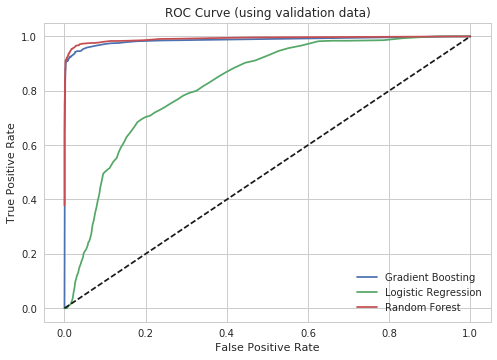

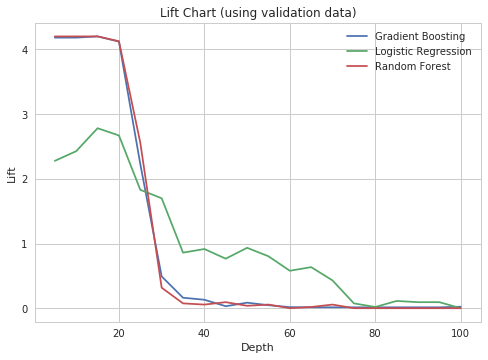

In [59]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["Model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["Model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

 ### End CAS session


In [58]:
#sess.close()